# Examining vaccination rates

The [Western Pennsylvania Regional Data Center](https://www.wprdc.org) collects, timestamps, and archives Pennsylvania's [public vaccination data](https://data.pa.gov/browse?q=vaccinations) as it updates. These [archived datasets](https://data.wprdc.org/dataset/weekly-pennsylvania-covid-19-vaccinations-stats-archive) allow for examination of vaccination rates over time.

## Zip code

### Get the data

In [92]:
import pandas
import pandas as pd

vac_race_zip_csv = "https://data.wprdc.org/datastore/dump/d3f5c6a6-c5f8-48db-8da2-f22a39bc8ef8"


def n2z(x) -> float:
    return float(0) if not x else float(x)


# converts null to 0 on the data fields
converters = {k: n2z for k in range(2, 16)}

df = pandas.read_csv(
    vac_race_zip_csv,
    parse_dates=['date_saved'],
    converters=converters,
    usecols=lambda c: c not in ['latitude', 'longitude', 'date_updated'],
    dtype={'patient_zip_code': str}
)
df.head()

,patient_zip_code,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,date_saved
0,17142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27
1,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27
2,19424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2021-07-27
3,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,2021-07-27
4,15426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27


### Mix-in demographic data

In [93]:
# Get zip_code demographic data and prepare to merge with vaccine data
demog_data_file = 'https://raw.githubusercontent.com/WPRDC/bec-vaccination-map/main/zip_code_pop_2019.csv'

source_demog_df = pd.read_csv(demog_data_file, dtype={'zip code tabulation area': str})

total_pop = source_demog_df['B01001_001E']
black_pop = source_demog_df['B01001B_001E']

# < 10 years populations
total_kid_pop = source_demog_df['B01001_003E'] + source_demog_df['B01001_004E'] + \
                source_demog_df['B01001_027E'] + source_demog_df['B01001_028E']

black_kid_pop = source_demog_df['B01001B_003E'] + source_demog_df['B01001B_004E'] + \
                source_demog_df['B01001B_018E'] + source_demog_df['B01001B_019E']

eligible_pop = total_pop - total_kid_pop.multiply(1.2)
eligible_black_pop = black_pop - black_kid_pop.multiply(1.2)

demog_df = pd.DataFrame({
    'zip_code': source_demog_df['zip code tabulation area'],
    'eligible_pop': eligible_pop,
    'eligible_black_pop': eligible_black_pop,
})
demog_df.head()

,zip_code,eligible_pop,eligible_black_pop
0,15320,4545.6,0.0
1,15321,1363.8,0.0
2,15325,322.2,0.0
3,15334,107.4,0.0
4,15348,213.0,0.0


In [94]:
# Join datasets

race_strings = ['african_american', 'asian', 'multiple_other', 'native_american', 'pacific_islander', 'white',
                'unknown']

# join the demographic data with the vax data
full_df = pd.merge(df, demog_df, left_on='patient_zip_code', right_on='zip_code')

# get total vaccine numbers
full_df['fully_covered_total'] = sum([full_df[f'fully_covered_{race_str}'] for race_str in race_strings])
full_df['fully_covered_total_known'] = sum(
    [full_df[f'fully_covered_{race_str}'] for race_str in race_strings if race_str != 'unknown'])

# calculate the percents
full_df['total_percent_fully_covered'] = full_df['fully_covered_total'] / full_df['eligible_pop']
full_df['total_known_percent_fully_covered'] = full_df['fully_covered_total_known'] / full_df['eligible_pop']
full_df['black_percent_full_covered'] = full_df['fully_covered_african_american'] / full_df['eligible_black_pop']

full_df

,patient_zip_code,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,...,fully_covered_unknown,date_saved,zip_code,eligible_pop,eligible_black_pop,fully_covered_total,fully_covered_total_known,total_percent_fully_covered,total_known_percent_fully_covered,black_percent_full_covered
0,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-07-27,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
1,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-02,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
2,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-09,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
3,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-16,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
4,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-23,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17955,18812,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,29.0,2021-08-30,18812,1508.2,0.0,289.0,260.0,0.191619,0.172391,NaN
17956,18812,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,29.0,2021-09-06,18812,1508.2,0.0,289.0,260.0,0.191619,0.172391,NaN
17957,18812,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,...,29.0,2021-09-13,18812,1508.2,0.0,292.0,263.0,0.193608,0.174380,NaN
17958,18812,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,...,29.0,2021-09-20,18812,1508.2,0.0,292.0,263.0,0.193608,0.174380,NaN


### Percent of eligible Black residents who are fully vaccinated per zip code
For zip codes `15104`, `15132`, `15206`, `15208`, `15210`, `15212`, `15214`, `15219`, `15221`, `15235`

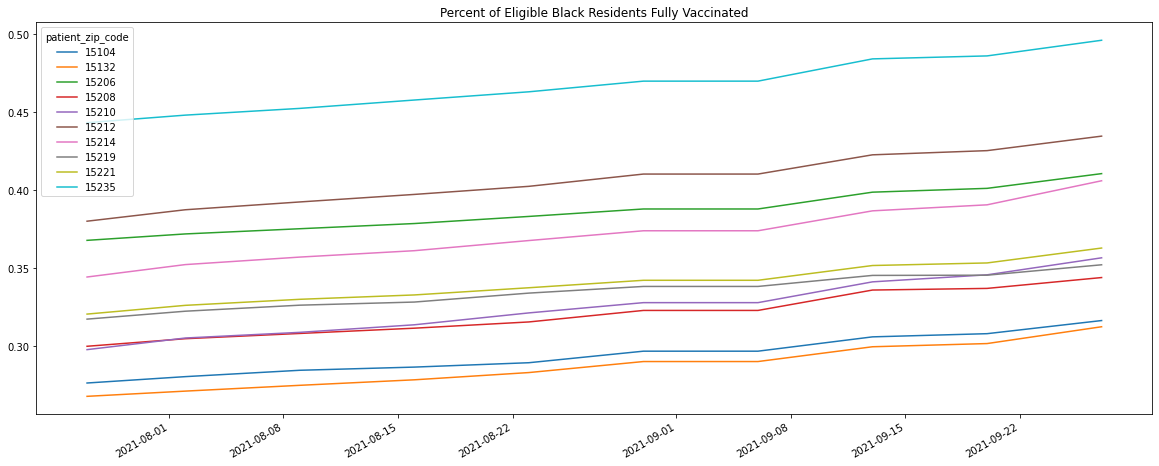

In [95]:
# Limit the dataset to the past month and select zipcodes
from datetime import datetime, timedelta

# start date being 30 days before today
start = datetime.now() - timedelta(days=90)

# filter for zipcodes that start '15'
local_zipcodes = lambda z: z[:2] == '15'

# filter zipcodes in Allegheny County with large proportion Black population
ac_black_zipcodes = ['15104', '15132', '15206', '15208', '15210', '15212', '15214', '15219', '15221', '15235', ]
full_df = full_df[(full_df['zip_code'].isin(ac_black_zipcodes)) & (full_df['date_saved'] > start)]

by_date_zip_pivot = full_df.pivot(index='date_saved', columns='patient_zip_code', values='black_percent_full_covered')
rate_plot = by_date_zip_pivot.plot(
    title='Percent of Eligible Black Residents Fully Vaccinated',
    xlabel='',
    figsize=(20, 8),
)

## Allegheny County
### Get the data

In [96]:
# get county data for comparison
county_csv = 'https://data.wprdc.org/datastore/dump/7272bc6b-7c7e-4a7f-9ec0-9ee034e6147e'
county_by_race_csv = 'https://data.wprdc.org/datastore/dump/a6f52fb9-6c3a-40e4-adc4-2bd806b165fd'

county_df = pd.read_csv(
    county_by_race_csv,
    parse_dates=['date_saved'],
    converters=converters,
    usecols=lambda c: c not in ['latitude', 'longitude', 'date_updated'],
)

# calculate totals
county_df['fully_covered_total'] = sum([county_df[f'fully_covered_{race_str}'] for race_str in race_strings])
county_df['fully_covered_total_known'] = sum(
    [county_df[f'fully_covered_{race_str}'] for race_str in race_strings if race_str != 'unknown'])

county_df['partially_covered_total'] = sum([county_df[f'partially_covered_{race_str}'] for race_str in race_strings])
county_df['partially_covered_total_known'] = sum(
    [county_df[f'partially_covered_{race_str}'] for race_str in race_strings if race_str != 'unknown'])

# limit to allegheny county
county_df = county_df[(county_df['county_name'].str.upper() == 'ALLEGHENY')]
county_df

,date_saved,county_name,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,fully_covered_total,fully_covered_total_known,partially_covered_total,partially_covered_total_known
1,2021-03-25,Allegheny,11739.0,92.0,9.0,352.0,11284.0,131861.0,20396.0,8166.0,127.0,22.0,382.0,17303.0,111860.0,23389.0,161249.0,137860.0,175733.0,155337.0
69,2021-03-29,Allegheny,15603.0,174.0,18.0,443.0,11548.0,151477.0,23188.0,9377.0,159.0,24.0,465.0,21065.0,134728.0,24328.0,190146.0,165818.0,202451.0,179263.0
137,2021-04-05,Allegheny,16607.0,294.0,35.0,679.0,12193.0,158553.0,25208.0,11714.0,169.0,28.0,524.0,23382.0,165904.0,26417.0,228138.0,201721.0,213569.0,188361.0
227,2021-04-12,ALLEGHENY,16862.0,354.0,43.0,982.0,14264.0,160825.0,26524.0,13371.0,208.0,29.0,574.0,26258.0,188769.0,28332.0,257541.0,229209.0,219854.0,193330.0
304,2021-04-19,ALLEGHENY,18273.0,399.0,47.0,1099.0,14537.0,171361.0,26698.0,16695.0,263.0,34.0,696.0,29031.0,225933.0,33684.0,306336.0,272652.0,232414.0,205716.0
387,2021-04-26,ALLEGHENY,17777.0,301.0,37.0,1112.0,13145.0,170541.0,26200.0,21549.0,412.0,46.0,1070.0,37357.0,268989.0,39730.0,369153.0,329423.0,229113.0,202913.0
445,2021-05-10,ALLEGHENY,19049.0,200.0,29.0,753.0,12060.0,162120.0,33064.0,26878.0,592.0,67.0,1722.0,45915.0,335348.0,48961.0,459483.0,410522.0,227275.0,194211.0
497,2021-05-17,ALLEGHENY,18154.0,142.0,27.0,584.0,11219.0,146632.0,30041.0,29460.0,663.0,69.0,1945.0,47813.0,363201.0,53350.0,496501.0,443151.0,206799.0,176758.0
589,2021-05-24,ALLEGHENY,18046.0,132.0,27.0,522.0,11574.0,142976.0,28291.0,31624.0,698.0,70.0,2026.0,49592.0,383602.0,56742.0,524354.0,467612.0,201568.0,173277.0
675,2021-05-31,ALLEGHENY,17967.0,409.0,40.0,486.0,11853.0,141113.0,26756.0,33191.0,1140.0,84.0,2086.0,50958.0,396606.0,58552.0,542617.0,484065.0,198624.0,171868.0


### Mix-in county-level demographic data

In [97]:
# Demographic data from from ACS 2019 (5yr agg)
county_pop = 1221744
county_black_pop = 157060

# For now, just getting eligible estimates for total and Black population. (times 1.2 to estimate < 12y/o)
ac_total_kid_pop = 125368 * 1.2     # acs tables for population counts < 10yr ['B01001_003E', 'B01001_004E', 'B01001_027E', 'B01001_028E' ]
ac_black_kid_pop = 21678 * 1.2      # acs tables ['B01001B_003E', 'B01001B_004E', 'B01001B_018E', 'B01001B_019E' ]

ac_eligible_total_pop = county_pop - ac_total_kid_pop
ac_eligible_black_pop = county_black_pop - ac_black_kid_pop

county_df['fully_covered_%_total'] = county_df['fully_covered_total'].divide(ac_eligible_total_pop)
county_df['fully_covered_%_total_known'] = county_df['fully_covered_total_known'].divide(ac_eligible_total_pop)
county_df['fully_covered_%_african_american'] = county_df['fully_covered_african_american'].divide(ac_eligible_black_pop)

county_df['partially_covered_%_total'] = county_df['partially_covered_total'].divide(ac_eligible_total_pop)
county_df['partially_covered_%_total_known'] = county_df['partially_covered_total_known'].divide(ac_eligible_total_pop)
county_df['partially_covered_%_african_american'] = county_df['partially_covered_african_american'].divide(ac_eligible_black_pop)
county_df

,date_saved,county_name,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,...,fully_covered_total,fully_covered_total_known,partially_covered_total,partially_covered_total_known,fully_covered_%_total,fully_covered_%_total_known,fully_covered_%_african_american,partially_covered_%_total,partially_covered_%_total_known,partially_covered_%_african_american
1,2021-03-25,Allegheny,11739.0,92.0,9.0,352.0,11284.0,131861.0,20396.0,8166.0,...,161249.0,137860.0,175733.0,155337.0,0.150517,0.128684,0.062314,0.164037,0.144998,0.089579
69,2021-03-29,Allegheny,15603.0,174.0,18.0,443.0,11548.0,151477.0,23188.0,9377.0,...,190146.0,165818.0,202451.0,179263.0,0.177491,0.154782,0.071555,0.188977,0.167332,0.119065
137,2021-04-05,Allegheny,16607.0,294.0,35.0,679.0,12193.0,158553.0,25208.0,11714.0,...,228138.0,201721.0,213569.0,188361.0,0.212954,0.188295,0.089388,0.199355,0.175824,0.126726
227,2021-04-12,ALLEGHENY,16862.0,354.0,43.0,982.0,14264.0,160825.0,26524.0,13371.0,...,257541.0,229209.0,219854.0,193330.0,0.240400,0.213954,0.102033,0.205221,0.180463,0.128672
304,2021-04-19,ALLEGHENY,18273.0,399.0,47.0,1099.0,14537.0,171361.0,26698.0,16695.0,...,306336.0,272652.0,232414.0,205716.0,0.285947,0.254505,0.127398,0.216945,0.192024,0.139439
387,2021-04-26,ALLEGHENY,17777.0,301.0,37.0,1112.0,13145.0,170541.0,26200.0,21549.0,...,369153.0,329423.0,229113.0,202913.0,0.344583,0.307498,0.164438,0.213864,0.189408,0.135654
445,2021-05-10,ALLEGHENY,19049.0,200.0,29.0,753.0,12060.0,162120.0,33064.0,26878.0,...,459483.0,410522.0,227275.0,194211.0,0.428901,0.383199,0.205103,0.212148,0.181285,0.145361
497,2021-05-17,ALLEGHENY,18154.0,142.0,27.0,584.0,11219.0,146632.0,30041.0,29460.0,...,496501.0,443151.0,206799.0,176758.0,0.463456,0.413656,0.224806,0.193035,0.164994,0.138531
589,2021-05-24,ALLEGHENY,18046.0,132.0,27.0,522.0,11574.0,142976.0,28291.0,31624.0,...,524354.0,467612.0,201568.0,173277.0,0.489455,0.436489,0.241319,0.188152,0.161744,0.137707
675,2021-05-31,ALLEGHENY,17967.0,409.0,40.0,486.0,11853.0,141113.0,26756.0,33191.0,...,542617.0,484065.0,198624.0,171868.0,0.506502,0.451847,0.253277,0.185404,0.160429,0.137104


(0.0, 0.698562659322079)

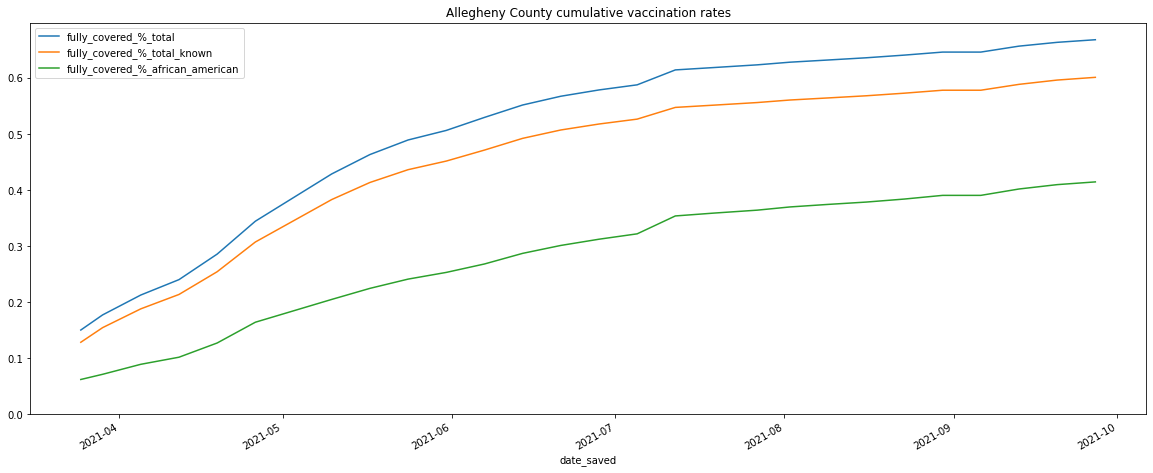

In [98]:
chart = county_df.plot(
    title='Allegheny County cumulative vaccination rates',
    figsize=(20, 8),
    x='date_saved',
    y=['fully_covered_%_total', 'fully_covered_%_total_known', 'fully_covered_%_african_american']
)
chart.set_ylim(bottom=0)

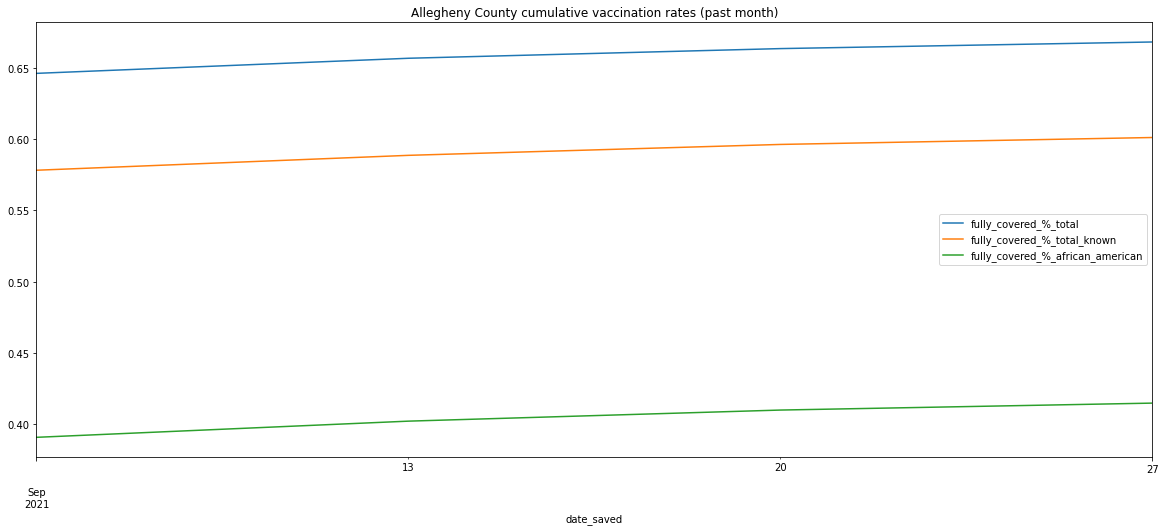

In [99]:
plot_start = datetime.now() - timedelta(days=30)
plot  = county_df[county_df['date_saved'] > plot_start].plot(
    title='Allegheny County cumulative vaccination rates (past month)',
    figsize=(20, 8),
    x='date_saved',
    y=['fully_covered_%_total', 'fully_covered_%_total_known', 'fully_covered_%_african_american'],
)
# chart.set_ylim(bottom=0)

(0.0, 0.22533880256405664)

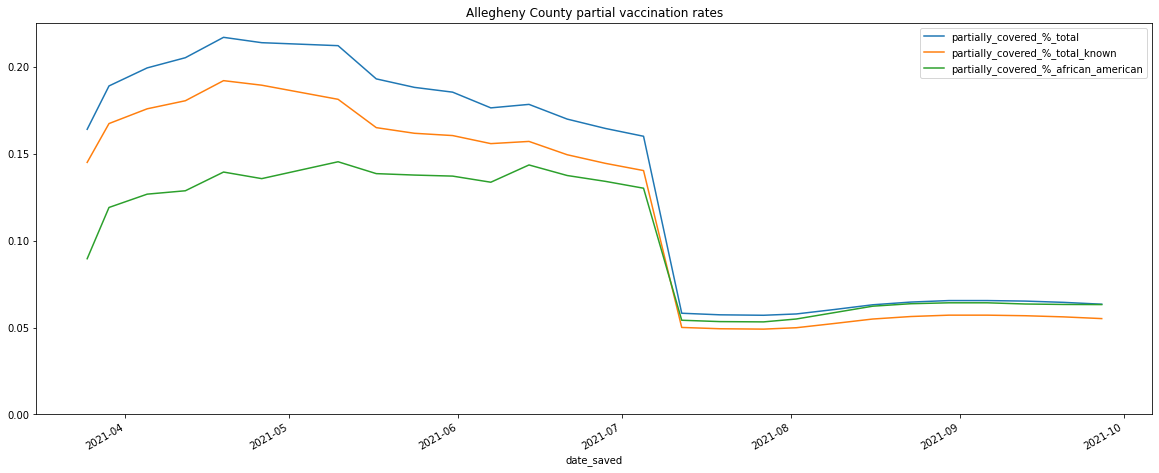

In [100]:
chart = county_df.plot(
    title='Allegheny County partial vaccination rates',
    figsize=(20, 8),
    x='date_saved',
    y=['partially_covered_%_total', 'partially_covered_%_total_known', 'partially_covered_%_african_american']
)
chart.set_ylim(bottom=0)

<AxesSubplot:title={'center':'Allegheny County partial vaccination rates (past month)'}, xlabel='date_saved'>

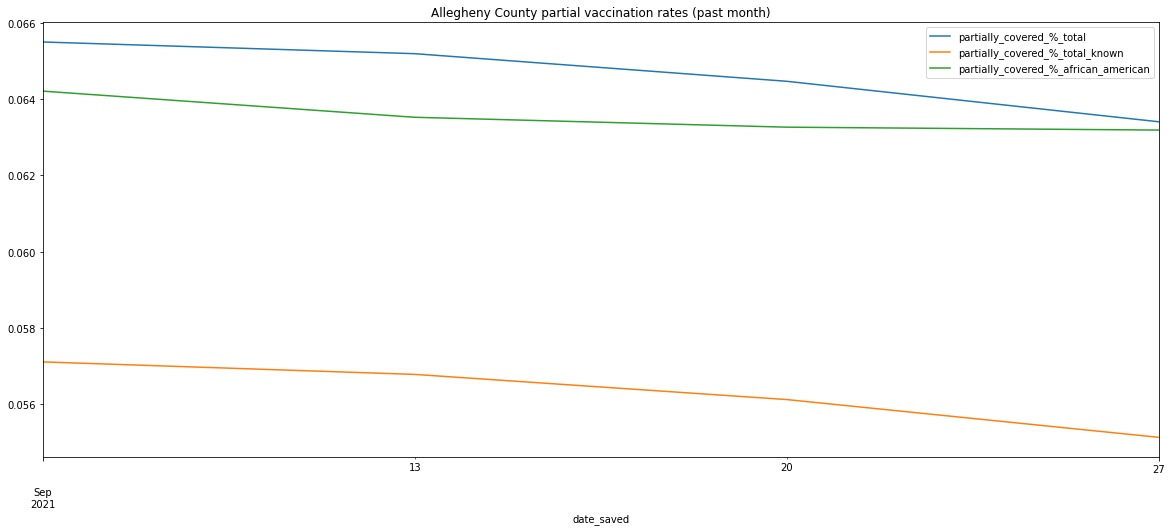

In [101]:
plot_start = datetime.now() - timedelta(days=30)
county_df[county_df['date_saved'] > plot_start].plot(
    title='Allegheny County partial vaccination rates (past month)',
    figsize=(20, 8),
    x='date_saved',
    y=['partially_covered_%_total', 'partially_covered_%_total_known', 'partially_covered_%_african_american'],
)
# chart.set_ylim(bottom=0)